# Different Optimizer - learning rate = 0.001

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

### Data loading

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Hyperparameters

In [3]:
ops = ['Adam', 'RMS', 'AdaGD', 'GD']
l_r = 0.001 # Learning rate
epoch = 2000
batch_size = 128

In [4]:
n_inputs = 28 # MNIST data input, img shape = (28, 28), view the graph row by row
n_steps = 28 # Time steps - shift 28 times
n_hidden_units = 128 # Neuron no. in hidden layer
n_classes = 10 # 0~9

### Placeholder - input and output data holders

In [5]:
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_classes])

### Create static initial parameters

In [6]:
# create static initial parameters
w_h1 = tf.random_normal([n_inputs, n_hidden_units])
w_out = tf.random_normal([n_hidden_units, n_classes])
b_h1 = tf.random_normal([n_hidden_units, ])
b_out = tf.random_normal([n_classes, ])

In [7]:
def get_static_w_b():
    # create static initial parameters
    w_h1 = tf.random_normal([n_inputs, n_hidden_units])
    w_out = tf.random_normal([n_hidden_units, n_classes])
    b_h1 = tf.random_normal([n_hidden_units, ])
    b_out = tf.random_normal([n_classes, ])
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        w_h1, w_out, b_h1, b_out = sess.run([w_h1, w_out, b_h1, b_out])
    weights = dict()
    biases = dict()
    # Create weights and biases for diff ops
    for op in ops:
        weights[op] = {
        # (28 inputs, 128 neurons)
        'h1':tf.Variable(tf.constant(w_h1)),
        # (128 inputs, 10 neurons)
        'out':tf.Variable(tf.constant(w_out))
        }
        biases[op] = {
        # (128 neurons, )
        'h1':tf.Variable(tf.constant(b_h1)),
        # (10 neurons, )
        'out':tf.Variable(tf.constant(b_out))
        }
    return weights, biases

### RNN structure

In [8]:
def RNN(X, weights, biases, op='Adam'):
    # h1
    X = tf.reshape(X, [-1, n_inputs])
    X_in = tf.matmul(X, weights[op]['h1']) + biases[op]['h1']
    X_in = tf.reshape(X_in, [-1, n_steps, n_hidden_units])
    
    with tf.variable_scope(op):
        # rnn cell
        rnn_cell = tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(n_hidden_units,
                                                              forget_bias=1.0,
                                                              state_is_tuple=True)
        _init_state = rnn_cell.zero_state(batch_size, dtype=tf.float32)
        # outputs: the rnns outputs
        outputs, states = tf.nn.dynamic_rnn(cell=rnn_cell,
                                            inputs=X_in,
                                            initial_state=_init_state,
                                            time_major=False)
    
    # output layer
    outputs = tf.unstack(tf.transpose(outputs, [1, 0, 2]))
    results = tf.matmul(outputs[-1], weights[op]['out']) + biases[op]['out']
    
    return results

In [9]:
def get_pred(x, weights, biases):
    pred = dict()
    for op in ops:
        pred[op] = RNN(x, weights, biases, op=op)
    return pred

def get_loss(pred, y):
    loss = dict()
    for op in ops:
        loss[op] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred[op], labels=y))
    return loss

def get_accu(pred, y):
    accu = dict()
    for op in ops:
        accu[op] = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred[op], 1), tf.argmax(y, 1)), tf.float32))
    return accu

def get_op(loss, l_r):
    train_op = dict()
    train_op['Adam'] = tf.train.AdamOptimizer(l_r).minimize(loss['Adam'])
    train_op['RMS'] = tf.train.RMSPropOptimizer(l_r).minimize(loss['RMS'])
    train_op['AdaGD'] = tf.train.AdagradOptimizer(l_r).minimize(loss['AdaGD'])
    train_op['GD'] = tf.train.GradientDescentOptimizer(l_r).minimize(loss['GD'])
    return train_op

In [10]:
ex_time = 0

### Experiments

In [11]:
import time
loss_val_train = dict()
loss_val_test = dict()
accu_val_train = dict()
accu_val_test = dict()
time_span = dict()
for op in ops:
    loss_val_train[op] = list()
    loss_val_test[op] = list()
    accu_val_train[op] = list()
    accu_val_test[op] = list()
    time_span[op] = list()
for ex in range(10):
    ex_time += 1
    with tf.variable_scope('ex'+str(ex_time)):
        weights, biases = get_static_w_b()
        pred = get_pred(x, weights, biases)
        loss = get_loss(pred, y)
        accu = get_accu(pred, y)
        train_op = get_op(loss, l_r)
    init2 = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init2)
        startTime = time.time()
        for epo in range(epoch):
            # read data
            batch_xs_train, batch_ys_train = mnist.train.next_batch(batch_size)
            batch_xs_train = batch_xs_train.reshape([batch_size, n_steps, n_inputs])
            # read testing data
            batch_xs_test, batch_ys_test = mnist.test.next_batch(batch_size)
            batch_xs_test = batch_xs_test.reshape([batch_size, n_steps, n_inputs])
            # Training and testing
            for op in ops:
                t1 = time.time()
                sess.run([train_op[op]], feed_dict={
                    x:batch_xs_train,
                    y:batch_ys_train
                })
                t2 = time.time()
                # save time-span
                time_span[op].append(t2-t1)
                # find loss and accuracy for training set
                l, a = sess.run([loss[op], accu[op]], feed_dict={
                    x:batch_xs_train,
                    y:batch_ys_train
                })
                loss_val_train[op].append(l)
                accu_val_train[op].append(a)
                # find loss and accuracy for testing set
                l, a = sess.run([loss[op], accu[op]], feed_dict={
                    x:batch_xs_test,
                    y:batch_ys_test
                })
                loss_val_test[op].append(l)
                accu_val_test[op].append(a)
            
            # print result each 100 epochs
            if (epo+1)%100 == 0:
                print('Epoch', epo+1,
                      ', Losses:', '%2.4f, %2.4f, %2.4f, %2.4f'\
                      % (loss_val_train['Adam'][-1], loss_val_train['RMS'][-1],
                         loss_val_train['AdaGD'][-1], loss_val_train['GD'][-1]),
                      ', Accuracies:', '%2.4f, %2.4f, %2.4f, %2.4f'\
                      % (accu_val_train['Adam'][-1], accu_val_train['RMS'][-1],
                         accu_val_train['AdaGD'][-1], accu_val_train['GD'][-1]))
        endTime = time.time()
        timespan = endTime - startTime
        print('--------------------EX'+str(ex+1), 'done.', 'Spent', '%2.2f' % timespan, 'secs.')
        #writer = tf.summary.FileWriter("logs/", sess.graph)
# tensorboard: terminal >> tensorboard --logdir='logs/'

#save the result
np.save('./diffOP_data/loss_val_train_diffOP_lr0.001', loss_val_train)
np.save('./diffOP_data/loss_val_test_diffOP_lr0.001', loss_val_test)
np.save('./diffOP_data/accu_val_train_diffOP_lr0.001', accu_val_train)
np.save('./diffOP_data/accu_val_test_diffOP_lr0.001', accu_val_test)
np.save('./diffOP_data/time_span_diffOP_lr0.001', time_span)

Epoch 100 , Losses: 0.7751, 1.5290, 1.5311, 1.8209 , Accuracies: 0.7344, 0.5625, 0.5391, 0.3750
Epoch 200 , Losses: 0.4750, 0.5626, 1.0874, 1.4670 , Accuracies: 0.8828, 0.7734, 0.6172, 0.5391
Epoch 300 , Losses: 0.3708, 0.1632, 0.6459, 0.9982 , Accuracies: 0.8906, 0.9453, 0.8125, 0.6953
Epoch 400 , Losses: 0.1438, 0.1156, 0.6532, 0.9446 , Accuracies: 0.9609, 0.9531, 0.7891, 0.7031
Epoch 500 , Losses: 0.2207, 0.1706, 0.7502, 1.0586 , Accuracies: 0.9297, 0.9297, 0.7656, 0.6719
Epoch 600 , Losses: 0.2439, 0.0770, 0.7256, 0.9083 , Accuracies: 0.9219, 0.9844, 0.8281, 0.7344
Epoch 700 , Losses: 0.0928, 0.0445, 0.6025, 0.7413 , Accuracies: 0.9844, 0.9922, 0.8359, 0.7500
Epoch 800 , Losses: 0.1389, 0.0645, 0.6109, 0.7970 , Accuracies: 0.9531, 0.9844, 0.8516, 0.7734
Epoch 900 , Losses: 0.1292, 0.0219, 0.5242, 0.7070 , Accuracies: 0.9609, 1.0000, 0.8438, 0.7656
Epoch 1000 , Losses: 0.0921, 0.0352, 0.4899, 0.6721 , Accuracies: 0.9766, 0.9844, 0.8359, 0.8203
Epoch 1100 , Losses: 0.0684, 0.0180, 0.

Epoch 400 , Losses: 0.1823, 0.1514, 0.7823, 1.0315 , Accuracies: 0.9453, 0.9688, 0.7656, 0.6328
Epoch 500 , Losses: 0.1511, 0.1171, 0.6464, 0.7241 , Accuracies: 0.9453, 0.9688, 0.8203, 0.7812
Epoch 600 , Losses: 0.1063, 0.0561, 0.6294, 0.8166 , Accuracies: 0.9453, 0.9844, 0.8047, 0.7188
Epoch 700 , Losses: 0.0968, 0.0309, 0.6105, 0.7095 , Accuracies: 0.9766, 1.0000, 0.8281, 0.7969
Epoch 800 , Losses: 0.1672, 0.1308, 0.6858, 0.8593 , Accuracies: 0.9375, 0.9609, 0.7578, 0.7031
Epoch 900 , Losses: 0.0530, 0.0255, 0.5694, 0.7057 , Accuracies: 0.9766, 1.0000, 0.8047, 0.7734
Epoch 1000 , Losses: 0.0790, 0.0109, 0.5903, 0.7209 , Accuracies: 0.9844, 1.0000, 0.8125, 0.7812
Epoch 1100 , Losses: 0.0906, 0.0271, 0.5759, 0.7569 , Accuracies: 0.9609, 0.9922, 0.8359, 0.7500
Epoch 1200 , Losses: 0.0720, 0.0147, 0.4834, 0.6121 , Accuracies: 0.9844, 1.0000, 0.8984, 0.7812
Epoch 1300 , Losses: 0.0302, 0.0239, 0.4144, 0.6336 , Accuracies: 0.9922, 0.9922, 0.8516, 0.7812
Epoch 1400 , Losses: 0.1170, 0.0621,

Epoch 700 , Losses: 0.0665, 0.0722, 0.6101, 0.7977 , Accuracies: 0.9844, 0.9922, 0.8281, 0.7578
Epoch 800 , Losses: 0.0597, 0.0089, 0.4306, 0.5955 , Accuracies: 0.9922, 1.0000, 0.8672, 0.8281
Epoch 900 , Losses: 0.0967, 0.0426, 0.4235, 0.6332 , Accuracies: 0.9688, 0.9844, 0.8828, 0.7812
Epoch 1000 , Losses: 0.0906, 0.0147, 0.4595, 0.5325 , Accuracies: 0.9688, 1.0000, 0.8516, 0.8281
Epoch 1100 , Losses: 0.0350, 0.0163, 0.3816, 0.5216 , Accuracies: 0.9844, 1.0000, 0.8906, 0.8594
Epoch 1200 , Losses: 0.0747, 0.0055, 0.5528, 0.6544 , Accuracies: 0.9766, 1.0000, 0.8047, 0.8047
Epoch 1300 , Losses: 0.0787, 0.0073, 0.4272, 0.5627 , Accuracies: 0.9609, 1.0000, 0.8828, 0.8438
Epoch 1400 , Losses: 0.0772, 0.0388, 0.4119, 0.4397 , Accuracies: 0.9688, 0.9922, 0.8672, 0.8516
Epoch 1500 , Losses: 0.0560, 0.0036, 0.3770, 0.5150 , Accuracies: 0.9766, 1.0000, 0.8516, 0.8047
Epoch 1600 , Losses: 0.0214, 0.0034, 0.3085, 0.4591 , Accuracies: 0.9922, 1.0000, 0.9219, 0.8750
Epoch 1700 , Losses: 0.0596, 0.02

## Result

In [12]:
epoch = 2000
ops = ['Adam', 'RMS', 'AdaGD', 'GD']
import numpy as np
loss_val_train = np.load('./diffOP_data/loss_val_train_diffOP_lr0.001.npy')
loss_val_test = np.load('./diffOP_data/loss_val_test_diffOP_lr0.001.npy')
accu_val_train = np.load('./diffOP_data/accu_val_train_diffOP_lr0.001.npy')
accu_val_test = np.load('./diffOP_data/accu_val_test_diffOP_lr0.001.npy')
time_span = np.load('./diffOP_data/time_span_diffOP_lr0.001.npy')

loss_val_train = loss_val_train[None][0]
loss_val_test = loss_val_test[None][0]
accu_val_train = accu_val_train[None][0]
accu_val_test = accu_val_test[None][0]
time_span = time_span[None][0]

In [13]:
# result ploting
import matplotlib.pyplot as plt

In [14]:
len(accu_val_train[op][-epoch:])

2000

### Epoch - Training loss & accuracy

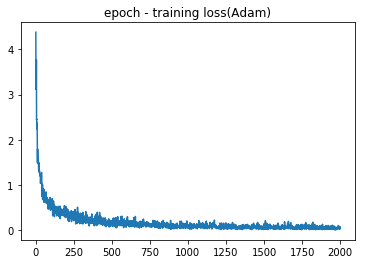

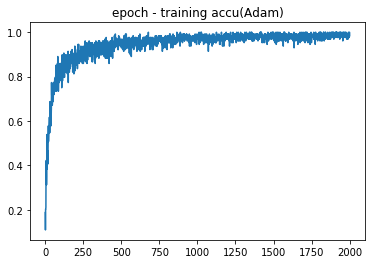

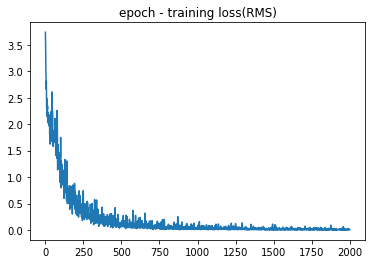

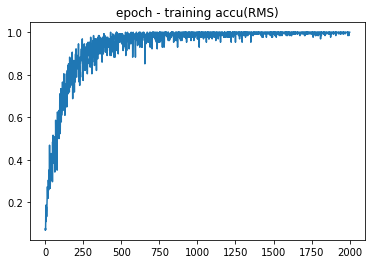

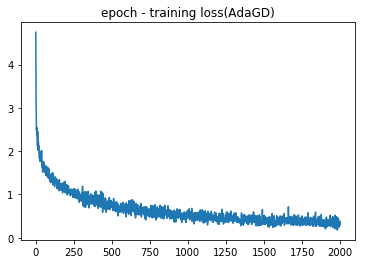

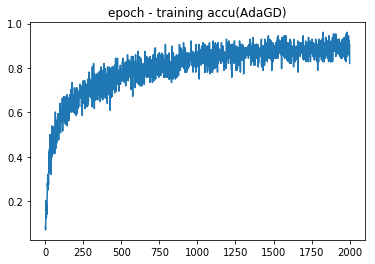

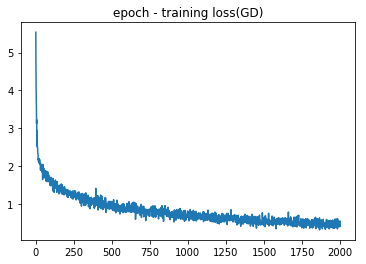

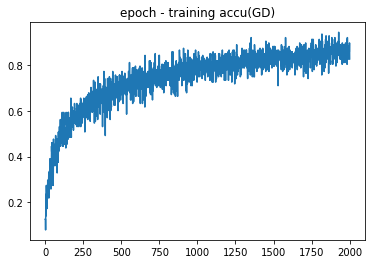

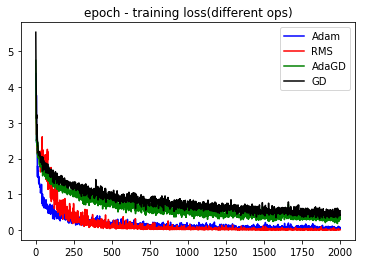

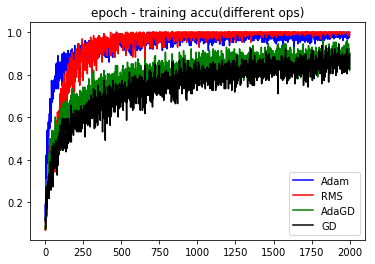

In [16]:
# epoch v.s.training loss
i = 0
for op, losses in loss_val_train.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(losses[-epoch:])+1), losses[-epoch:])
    plt.title('epoch - training loss('+op+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(accu_val_train[op][-epoch:])+1), accu_val_train[op][-epoch:])
    plt.title('epoch - training accu('+op+')')  
    plt.show()
    i += 1
    
plt.plot(range(1, len(loss_val_train['Adam'][-epoch:])+1), loss_val_train['Adam'][-epoch:], 'b',
         range(1, len(loss_val_train['RMS'][-epoch:])+1), loss_val_train['RMS'][-epoch:], 'r',
         range(1, len(loss_val_train['AdaGD'][-epoch:])+1), loss_val_train['AdaGD'][-epoch:], 'g',
         range(1, len(loss_val_train['GD'][-epoch:])+1), loss_val_train['GD'][-epoch:], 'k')
plt.title('epoch - training loss(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=1)
plt.show()

plt.plot(range(1, len(accu_val_train['Adam'][-epoch:])+1), accu_val_train['Adam'][-epoch:], 'b',
         range(1, len(accu_val_train['RMS'][-epoch:])+1), accu_val_train['RMS'][-epoch:], 'r',
         range(1, len(accu_val_train['AdaGD'][-epoch:])+1), accu_val_train['AdaGD'][-epoch:], 'g',
         range(1, len(accu_val_train['GD'][-epoch:])+1), accu_val_train['GD'][-epoch:], 'k')
plt.title('epoch - training accu(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=4)

plt.show()

### Epoch - Testing loss & accuracy

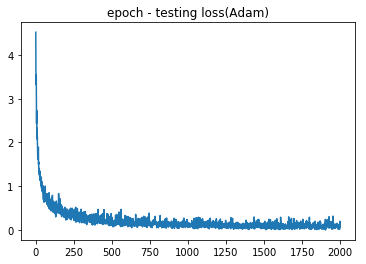

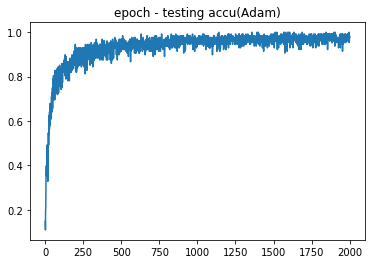

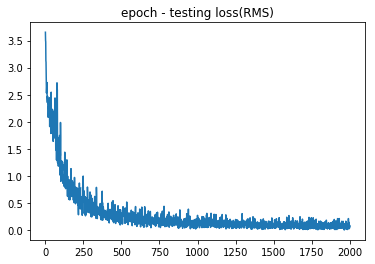

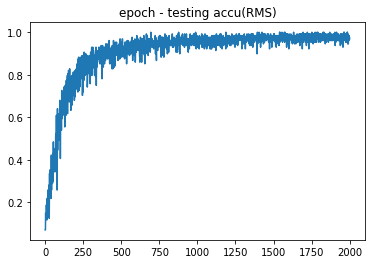

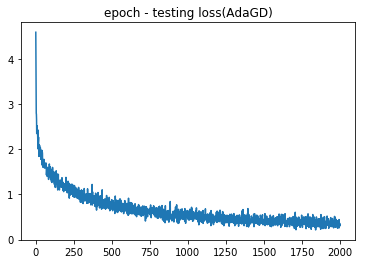

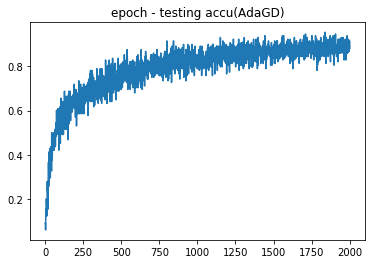

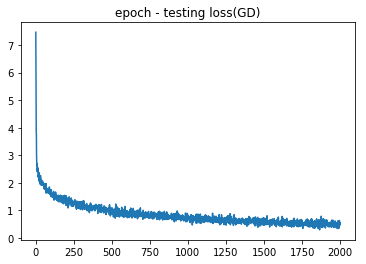

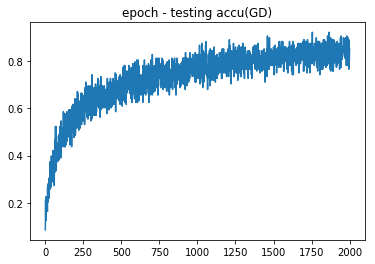

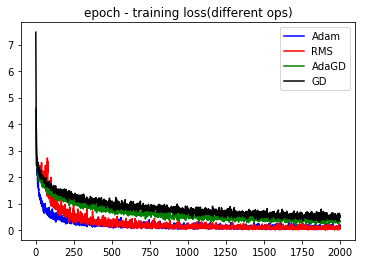

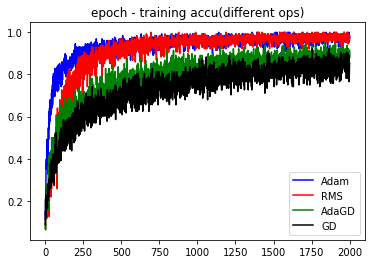

In [17]:
# epoch v.s. testing loss
i = 0
for op, losses in loss_val_test.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(losses[-epoch:])+1), losses[-epoch:])
    plt.title('epoch - testing loss('+op+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(accu_val_test[op][-epoch:])+1), accu_val_test[op][-epoch:])
    plt.title('epoch - testing accu('+op+')')  
    plt.show()
    i += 1
    
plt.plot(range(1, len(loss_val_test['Adam'][-epoch:])+1), loss_val_test['Adam'][-epoch:], 'b',
         range(1, len(loss_val_test['RMS'][-epoch:])+1), loss_val_test['RMS'][-epoch:], 'r',
         range(1, len(loss_val_test['AdaGD'][-epoch:])+1), loss_val_test['AdaGD'][-epoch:], 'g',
         range(1, len(loss_val_test['GD'][-epoch:])+1), loss_val_test['GD'][-epoch:], 'k')
plt.title('epoch - training loss(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=1)
plt.show()

plt.plot(range(1, len(accu_val_test['Adam'][-epoch:])+1), accu_val_test['Adam'][-epoch:], 'b',
         range(1, len(accu_val_test['RMS'][-epoch:])+1), accu_val_test['RMS'][-epoch:], 'r',
         range(1, len(accu_val_test['AdaGD'][-epoch:])+1), accu_val_test['AdaGD'][-epoch:], 'g',
         range(1, len(accu_val_test['GD'][-epoch:])+1), accu_val_test['GD'][-epoch:], 'k')
plt.title('epoch - training accu(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=4)

plt.show()

In [18]:
# smooth the line
len(loss_val_train['Adam']) # 782
last_point = 0
loss_val_train_ = dict()
loss_val_test_ = dict()
accu_val_train_ = dict()
accu_val_test_ = dict()
for op in ops:
    # training loss
    loss_val_train_[op] = list()
    loss_list = loss_val_train[op][-epoch:]
    for i in range(int(len(loss_list)/10)):
        loss_val_train_[op].append(np.mean(loss_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(loss_list)%10 != 0:
        loss_val_train_[op].append(np.mean(loss_list[last_point:]))
    # testing loss
    loss_val_test_[op] = list()
    loss_list = loss_val_test[op][-epoch:]
    for i in range(int(len(loss_list)/10)):
        loss_val_test_[op].append(np.mean(loss_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(loss_list)%10 != 0:
        loss_val_test_[op].append(np.mean(loss_list[last_point:]))
    # training accu
    accu_val_train_[op] = list()
    accu_list = accu_val_train[op][-epoch:]
    for i in range(int(len(accu_list)/10)):
        accu_val_train_[op].append(np.mean(accu_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(accu_list)%10 != 0:
        accu_val_train_[op].append(np.mean(accu_list[last_point:]))
    # testing accu
    accu_val_test_[op] = list()
    accu_list = accu_val_test[op][-epoch:]
    for i in range(int(len(accu_list)/10)):
        accu_val_test_[op].append(np.mean(accu_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(accu_list)%10 != 0:
        accu_val_test_[op].append(np.mean(accu_list[last_point:]))

### Epoch - Training loss & accuracy (smooth)

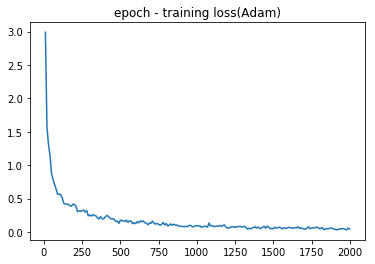

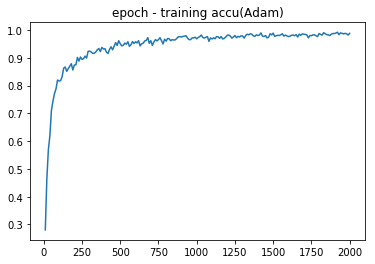

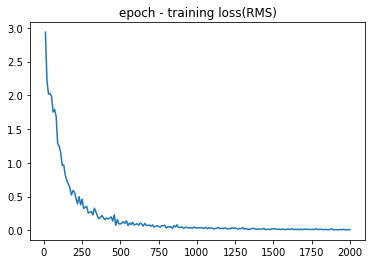

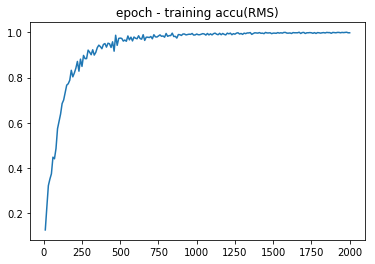

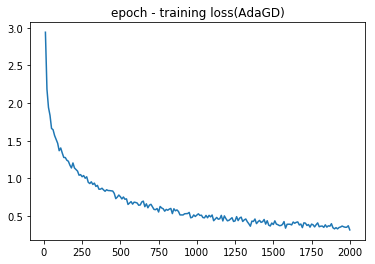

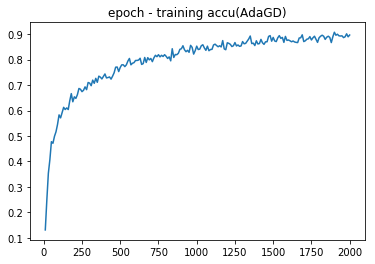

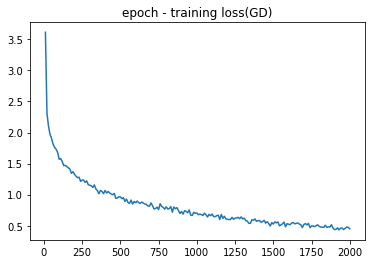

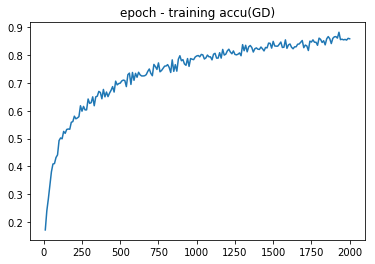

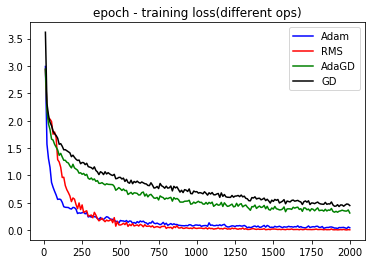

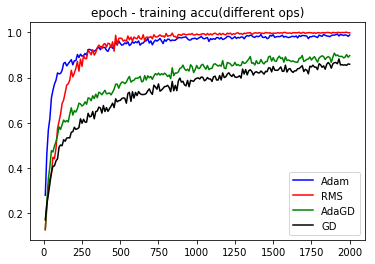

In [20]:
# epoch v.s.training loss & accu - smooth
i = 0
for op, losses in loss_val_train_.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(losses[-epoch:])*10+10, 10), losses[-epoch:])
    plt.title('epoch - training loss('+op+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(accu_val_train_[op][-epoch:])*10+10, 10), accu_val_train_[op][-epoch:])
    plt.title('epoch - training accu('+op+')')  
    plt.show()
    i += 1
    
plt.plot(range(10, len(loss_val_train_['Adam'][-epoch:])*10+10, 10), loss_val_train_['Adam'][-epoch:], 'b',
         range(10, len(loss_val_train_['RMS'][-epoch:])*10+10, 10), loss_val_train_['RMS'][-epoch:], 'r',
         range(10, len(loss_val_train_['AdaGD'][-epoch:])*10+10, 10), loss_val_train_['AdaGD'][-epoch:], 'g',
         range(10, len(loss_val_train_['GD'][-epoch:])*10+10, 10), loss_val_train_['GD'][-epoch:], 'k')
plt.title('epoch - training loss(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=1)
plt.savefig('./diffOP_data/epoch_loss_train_0.001.png')
plt.show()

plt.plot(range(10, len(accu_val_train_['Adam'][-epoch:])*10+10, 10), accu_val_train_['Adam'][-epoch:], 'b',
         range(10, len(accu_val_train_['RMS'][-epoch:])*10+10, 10), accu_val_train_['RMS'][-epoch:], 'r',
         range(10, len(accu_val_train_['AdaGD'][-epoch:])*10+10, 10), accu_val_train_['AdaGD'][-epoch:], 'g',
         range(10, len(accu_val_train_['GD'][-epoch:])*10+10, 10), accu_val_train_['GD'][-epoch:], 'k')
plt.title('epoch - training accu(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=4)
plt.savefig('./diffOP_data/epoch_accu_train_0.001.png')
plt.show()

### Epoch - Testing loss & accuracy (smooth)

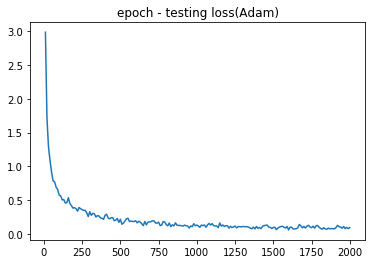

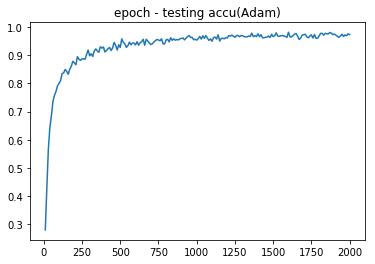

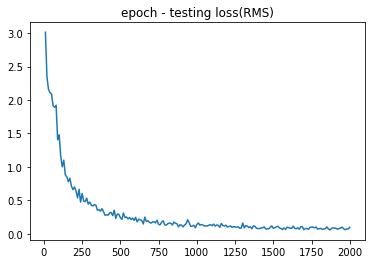

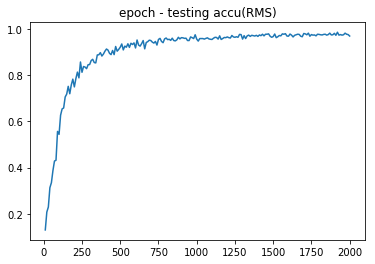

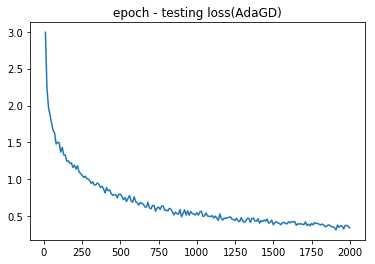

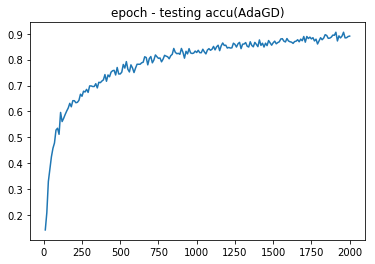

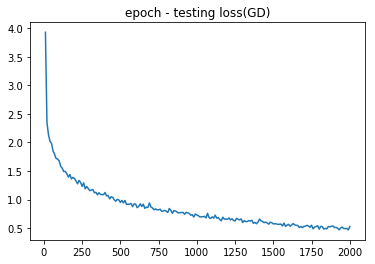

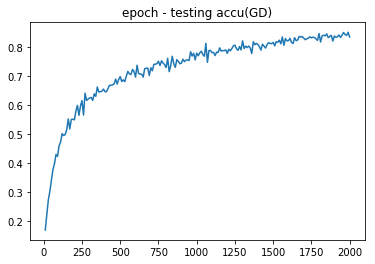

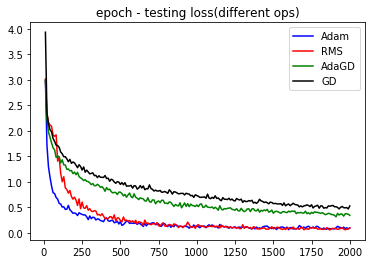

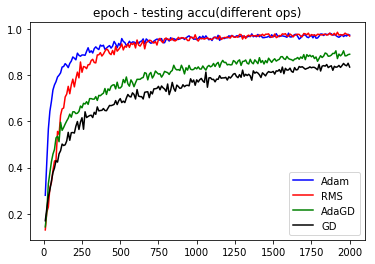

In [21]:
# epoch v.s.testing loss - smooth
i = 0
for op, losses in loss_val_test_.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(losses[-epoch:])*10+10, 10), losses[-epoch:])
    plt.title('epoch - testing loss('+op+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(accu_val_test_[op][-epoch:])*10+10, 10), accu_val_test_[op][-epoch:])
    plt.title('epoch - testing accu('+op+')')  
    plt.show()
    i += 1
    
plt.plot(range(10, len(loss_val_test_['Adam'][-epoch:])*10+10, 10), loss_val_test_['Adam'][-epoch:], 'b',
         range(10, len(loss_val_test_['RMS'][-epoch:])*10+10, 10), loss_val_test_['RMS'][-epoch:], 'r',
         range(10, len(loss_val_test_['AdaGD'][-epoch:])*10+10, 10), loss_val_test_['AdaGD'][-epoch:], 'g',
         range(10, len(loss_val_test_['GD'][-epoch:])*10+10, 10), loss_val_test_['GD'][-epoch:], 'k')
plt.title('epoch - testing loss(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=1)
plt.savefig('./diffOP_data/epoch_loss_test_0.001.png')
plt.show()

plt.plot(range(10, len(accu_val_test_['Adam'][-epoch:])*10+10, 10), accu_val_test_['Adam'][-epoch:], 'b',
         range(10, len(accu_val_test_['RMS'][-epoch:])*10+10, 10), accu_val_test_['RMS'][-epoch:], 'r',
         range(10, len(accu_val_test_['AdaGD'][-epoch:])*10+10, 10), accu_val_test_['AdaGD'][-epoch:], 'g',
         range(10, len(accu_val_test_['GD'][-epoch:])*10+10, 10), accu_val_test_['GD'][-epoch:], 'k')
plt.title('epoch - testing accu(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=4)
plt.savefig('./diffOP_data/epoch_accu_test_0.001.png')
plt.show()

# Statistics Inference : ANOVA and T-test

In [22]:
from scipy import stats as st
# ANOVA:  f_val, p_val = st.f_oneway(data_array1, data_array2, ...)

In [23]:
# data extract
loss_means_train = dict()
for op, losses in loss_val_train.items():
    mean = list()
    ex_time = len(losses)/epoch
    print(op, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(losses[(ex+1)*epoch-100:(ex+1)*epoch]))
    loss_means_train[op] = mean

loss_means_test = dict()
for op, losses in loss_val_test.items():
    mean = list()
    ex_time = len(losses)/epoch
    
    print(op, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(losses[(ex+1)*epoch-100:(ex+1)*epoch]))
    loss_means_test[op] = mean

accu_means_train = dict()
for op, accus in accu_val_train.items():
    mean = list()
    ex_time = len(accus)/epoch
    
    print(op, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(accus[(ex+1)*epoch-100:(ex+1)*epoch]))
    accu_means_train[op] = mean
    
accu_means_test = dict()
for op, accus in accu_val_test.items():
    mean = list()
    ex_time = len(accus)/epoch
    
    print(op, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(accus[(ex+1)*epoch-100:(ex+1)*epoch]))
    accu_means_test[op] = mean
    

    

Adam 10.0
RMS 10.0
AdaGD 10.0
GD 10.0
Adam 10.0
RMS 10.0
AdaGD 10.0
GD 10.0
Adam 10.0
RMS 10.0
AdaGD 10.0
GD 10.0
Adam 10.0
RMS 10.0
AdaGD 10.0
GD 10.0


In [24]:
print(np.mean(time_span['Adam']), np.mean(time_span['RMS']), 
      np.mean(time_span['AdaGD']), np.mean(time_span['GD']))


0.0109332560778 0.0109114220977 0.0108385697484 0.0108544571757


In [25]:
np.save('./diffOP_data/loss_means_train_diffOP_lr0.001', loss_means_train)
np.save('./diffOP_data/loss_means_test_diffOP_lr0.001', loss_means_test)
np.save('./diffOP_data/accu_means_train_diffOP_lr0.001', accu_means_train)
np.save('./diffOP_data/accu_means_test_diffOP_lr0.001', accu_means_test)
loss_means_train, loss_means_test, accu_means_train, accu_means_test

({'AdaGD': [0.36868727,
   0.38631016,
   0.35529399,
   0.36244124,
   0.36164257,
   0.34507722,
   0.37224752,
   0.35703206,
   0.35391262,
   0.34737137],
  'Adam': [0.052893057,
   0.050258923,
   0.050597873,
   0.050349832,
   0.036826931,
   0.051930457,
   0.048906773,
   0.046192206,
   0.047520712,
   0.043766007],
  'GD': [0.44614395,
   0.45543849,
   0.45377034,
   0.47113624,
   0.45586044,
   0.45009378,
   0.49812627,
   0.43860826,
   0.41883728,
   0.4558486],
  'RMS': [0.0098860981,
   0.011720542,
   0.0099406838,
   0.0096903965,
   0.0068374751,
   0.0090662194,
   0.008943188,
   0.0092240162,
   0.0068867244,
   0.008696992]},
 {'AdaGD': [0.37130123,
   0.41187409,
   0.36375913,
   0.37936291,
   0.37494496,
   0.356702,
   0.38593891,
   0.37027609,
   0.36133912,
   0.35609841],
  'Adam': [0.085332572,
   0.10168189,
   0.077929609,
   0.079551488,
   0.076182887,
   0.070837006,
   0.092853181,
   0.086841911,
   0.078837708,
   0.099387772],
  'GD': [0.48

### training loss

In [26]:
# ANOVA - find that whether ops effect the training loss or not
alpha = 0.05
f_val, p_val = st.f_oneway(loss_means_train['Adam'],
                           loss_means_train['RMS'],
                           loss_means_train['AdaGD'],
                           loss_means_train['GD'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')
print('')

# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(loss_means_train[op])
    StD[op] = np.std(loss_means_train[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP      mean     StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.4f   %2.4f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))
print('')

# t-test for each means
compare_flag = list() 
alpha = 0.05
for i in range(len(loss_means_train)-1):
    t_val, p_val = st.ttest_ind(loss_means_train[ops_sort[len(loss_means_train)-1-i]],
                                loss_means_train[ops_sort[len(loss_means_train)-2-i]],
                                equal_var=False)
    print('t value:', t_val, ', P value:', p_val)
    if p_val <= alpha:
        print(ops_sort[len(loss_means_train)-1-i] + ' > ' + ops_sort[len(loss_means_train)-2-i])
        compare_flag.append('>')
    else:
        print(ops_sort[len(loss_means_train)-1-i] + ' = ' + ops_sort[len(loss_means_train)-2-i])
        compare_flag.append('=')
    print('')

F value: 3316.42198637 , P value: 5.1665851172e-44
They are NOT identical at all.

         OP      mean     StD    
         RMS    0.0091   0.0014
        Adam    0.0479   0.0045
       AdaGD    0.3610   0.0117
          GD    0.4544   0.0195

t value: 12.3270332917 , P value: 3.68522222531e-09
GD > AdaGD

t value: 74.9518387479 , P value: 5.65197164556e-17
AdaGD > Adam

t value: 24.6961966608 , P value: 9.66232486119e-11
Adam > RMS



In [27]:
# result
print('Loss::',
      ops_sort[3], compare_flag[0], 
      ops_sort[2], compare_flag[1], 
      ops_sort[1], compare_flag[2],
      ops_sort[0])

Loss:: GD > AdaGD > Adam > RMS


### training accuracy

In [28]:
# ANOVA - find that whether ops effect the training accuracy or not
alpha = 0.05
f_val, p_val = st.f_oneway(accu_means_train['Adam'],
                           accu_means_train['RMS'],
                           accu_means_train['AdaGD'],
                           accu_means_train['GD'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')
print('')
# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(accu_means_train[op])
    StD[op] = np.std(accu_means_train[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP      mean     StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.4f   %2.4f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))
print('')
# t-test for each means
compare_flag = list() 
alpha = 0.05
for i in range(len(accu_means_train)-1):
    t_val, p_val = st.ttest_ind(accu_means_train[ops_sort[len(accu_means_train)-1-i]],
                                accu_means_train[ops_sort[len(accu_means_train)-2-i]],
                                equal_var=False)
    print('t value:', t_val, ', P value:', p_val)
    if p_val <= alpha:
        print(ops_sort[len(accu_means_train)-1-i] + ' > ' + ops_sort[len(accu_means_train)-2-i])
        compare_flag.append('>')
    else:
        print(ops_sort[len(accu_means_train)-1-i] + ' = ' + ops_sort[len(accu_means_train)-2-i])
        compare_flag.append('=')
    print('')

F value: 2850.93411241 , P value: 7.77622950955e-43
They are NOT identical at all.

         OP      mean     StD    
          GD    0.8598   0.0060
       AdaGD    0.8869   0.0047
        Adam    0.9857   0.0015
         RMS    0.9983   0.0005

t value: 24.1403561118 , P value: 1.29058263633e-10
RMS > Adam

t value: 59.47223325 , P value: 6.3273954527e-15
Adam > AdaGD

t value: 10.6429850832 , P value: 5.85357700476e-09
AdaGD > GD



In [29]:
# result
print('Accuracy::',
      ops_sort[3], compare_flag[0], 
      ops_sort[2], compare_flag[1], 
      ops_sort[1], compare_flag[2],
      ops_sort[0])

Accuracy:: RMS > Adam > AdaGD > GD


### testing loss

In [30]:
# ANOVA - find that whether ops effect the testing loss or not
alpha = 0.05
f_val, p_val = st.f_oneway(loss_means_test['Adam'],
                           loss_means_test['RMS'],
                           loss_means_test['AdaGD'],
                           loss_means_test['GD'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')
print('')
# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(loss_means_test[op])
    StD[op] = np.std(loss_means_test[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP      mean     StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.4f   %2.4f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))
print('')
# t-test for each means
compare_flag = list() 
alpha = 0.05
for i in range(len(loss_means_test)-1):
    t_val, p_val = st.ttest_ind(loss_means_test[ops_sort[len(loss_means_test)-1-i]],
                                loss_means_test[ops_sort[len(loss_means_test)-2-i]],
                                equal_var=False)
    print('t value:', t_val, ', P value:', p_val)
    if p_val <= alpha:
        print(ops_sort[len(loss_means_test)-1-i] + ' > ' + ops_sort[len(loss_means_test)-2-i])
        compare_flag.append('>')
    else:
        print(ops_sort[len(loss_means_test)-1-i] + ' = ' + ops_sort[len(loss_means_test)-2-i])
        compare_flag.append('=')
    print('')

F value: 1650.84078757 , P value: 1.37225775872e-38
They are NOT identical at all.

         OP      mean     StD    
         RMS    0.0768   0.0055
        Adam    0.0849   0.0097
       AdaGD    0.3732   0.0158
          GD    0.4894   0.0238

t value: 12.2028538625 , P value: 2.07843504081e-09
GD > AdaGD

t value: 46.5375543346 , P value: 1.35845137588e-17
AdaGD > Adam

t value: 2.18879269901 , P value: 0.0457258519315
Adam > RMS



In [31]:
# result
print('Loss::',
      ops_sort[3], compare_flag[0], 
      ops_sort[2], compare_flag[1], 
      ops_sort[1], compare_flag[2],
      ops_sort[0])

Loss:: GD > AdaGD > Adam > RMS


### testing accuracy

In [32]:
# ANOVA - find that whether ops effect the testing accuracy or not
alpha = 0.05
f_val, p_val = st.f_oneway(accu_means_test['Adam'],
                           accu_means_test['RMS'],
                           accu_means_test['AdaGD'],
                           accu_means_test['GD'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')
print('')
# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(accu_means_test[op])
    StD[op] = np.std(accu_means_test[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP      mean     StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.4f   %2.4f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))
print('')
# t-test for each means
compare_flag = list() 
alpha = 0.05
for i in range(len(accu_means_test)-1):
    t_val, p_val = st.ttest_ind(accu_means_test[ops_sort[len(accu_means_test)-1-i]],
                                accu_means_test[ops_sort[len(accu_means_test)-2-i]],
                                equal_var=False)
    print('t value:', t_val, ', P value:', p_val)
    if p_val <= alpha:
        print(ops_sort[len(accu_means_test)-1-i] + ' > ' + ops_sort[len(accu_means_test)-2-i])
        compare_flag.append('>')
    else:
        print(ops_sort[len(accu_means_test)-1-i] + ' = ' + ops_sort[len(accu_means_test)-2-i])
        compare_flag.append('=')
    print('')

F value: 1427.44675141 , P value: 1.84074975021e-37
They are NOT identical at all.

         OP      mean     StD    
          GD    0.8434   0.0092
       AdaGD    0.8828   0.0044
        Adam    0.9742   0.0026
         RMS    0.9766   0.0011

t value: 2.52597167124 , P value: 0.0263385513529
RMS > Adam

t value: 53.9517539096 , P value: 3.3101783627e-18
Adam > AdaGD

t value: 11.5416469587 , P value: 3.76453919528e-08
AdaGD > GD



In [33]:
# result
print('Accuracy::',
      ops_sort[3], compare_flag[0], 
      ops_sort[2], compare_flag[1], 
      ops_sort[1], compare_flag[2],
      ops_sort[0])

Accuracy:: RMS > Adam > AdaGD > GD


## Training time span

In [34]:
# ANOVA - find that whether ops effect the training loss or not
alpha = 0.05
f_val, p_val = st.f_oneway(time_span['Adam'],
                           time_span['RMS'],
                           time_span['AdaGD'],
                           time_span['GD'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')
print('')
# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(time_span[op])
    StD[op] = np.std(time_span[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP        mean          StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.8f   %2.8f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))
print('')
# t-test for each means
compare_flag = list() 
alpha = 0.05
for i in range(len(time_span)-1):
    t_val, p_val = st.ttest_ind(time_span[ops_sort[len(accu_means_test)-1-i]],
                                time_span[ops_sort[len(accu_means_test)-2-i]],
                                equal_var=False)
    print('t value:', t_val, ', P value:', p_val)
    if p_val <= alpha:
        print(ops_sort[len(time_span)-1-i] + ' > ' + ops_sort[len(time_span)-2-i])
        compare_flag.append('>')
    else:
        print(ops_sort[len(time_span)-1-i] + ' = ' + ops_sort[len(time_span)-2-i])
        compare_flag.append('=')
    print('')

F value: 15.5917602112 , P value: 3.90547802258e-10
They are NOT identical at all.

         OP        mean          StD    
       AdaGD    0.01083857   0.00149510
          GD    0.01085446   0.00149236
         RMS    0.01091142   0.00157038
        Adam    0.01093326   0.00187827

t value: 1.26118717003 , P value: 0.20724900654
Adam = RMS

t value: 3.71856609242 , P value: 0.00020063100632
RMS > GD

t value: 1.06358051669 , P value: 0.287525193346
GD = AdaGD

